## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer, classification_report, roc_auc_score
import sqlite3
import datetime
import scikitplot as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

from sklearn.externals.joblib import parallel_backend

import warnings
warnings.filterwarnings('ignore')
global_start = datetime.datetime.now()

## Read Data into Pandas Dataframe

In [2]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
conn.close()

print('Shape of our data : {}'.format(data.shape))
data.head(3)    

Shape of our data : (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


## Randomly Sample 100k points from 364k points

In [3]:
sample_data = data.sample(n=100000, random_state=42).reset_index(drop=True)
del data # To free up the RAM
print('shape of our sampled data : {}'.format(sample_data.shape))
print('\n Distribution of class label : \n{}'.format(sample_data['Score'].value_counts(normalize=True)))
sample_data.head(3)

shape of our sampled data : (100000, 11)

 Distribution of class label : 
positive    0.84356
negative    0.15644
Name: Score, dtype: float64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,474309,B003L1XMAA,A2BS25CMKABXK5,"Lela ""Lela""",4,4,positive,1309996800,Delicious,Too busy enjoying this wonderful lavender extr...,busy enjoying wonderful lavender extract homem...
1,474247,B005IU1NLC,A1OTUKJ8298TY5,Elizabeth MccArthy,0,0,positive,1317600000,So yummy,These are sooooo good! I had to find them on h...,sooooo good find since sell single packet supe...
2,343379,B00004RBDU,A28ZA79VMCI8W1,"Linda Khan ""kittykatkhan""",2,2,positive,1257206400,Flea Trap WORKS!,"In the past, I have used a metal type flea tra...",past used metal type flea trap owned operated ...


## Create a feature based on length of the Review

In [4]:
sample_data['length'] = sample_data['Text'].apply(lambda x : len(x))
sample_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,length
0,474309,B003L1XMAA,A2BS25CMKABXK5,"Lela ""Lela""",4,4,positive,1309996800,Delicious,Too busy enjoying this wonderful lavender extr...,busy enjoying wonderful lavender extract homem...,170
1,474247,B005IU1NLC,A1OTUKJ8298TY5,Elizabeth MccArthy,0,0,positive,1317600000,So yummy,These are sooooo good! I had to find them on h...,sooooo good find since sell single packet supe...,143
2,343379,B00004RBDU,A28ZA79VMCI8W1,"Linda Khan ""kittykatkhan""",2,2,positive,1257206400,Flea Trap WORKS!,"In the past, I have used a metal type flea tra...",past used metal type flea trap owned operated ...,759


## Time Based Splitting
We arrange the sampled data in ascending order of Time column and split the data without shuffling such that:

* Train_data = First 70%
* Test_data = Last 30%

In [5]:
# Sort by Time
sample_data = sample_data.sort_values('Time').reset_index(drop=True)

X_text = sample_data.iloc[:,10] # Selecting the 'CleanedText' column
y = sample_data.iloc[:,6] # Selecting the 'Score' column

# Split the data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_text_train : {}'.format(X_text_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_test : {}'.format(X_text_test.shape))
print('Shape of y_test : {}'.format(y_test.shape))

Shape of X_text_train : (70000,)
Shape of y_train : (70000,)

Shape of X_text_test : (30000,)
Shape of y_test : (30000,)


## Modelling
We will Create a **Logistic Regression** based classification model using the following features:

* Binary Bag Of Words 
* Count based Bag Of words 
* TFIDF 
* AVG Word2Vec
* TFIDF weighted Word2Vec

### Create Features
The function below will convert raw text to the designated features

In [6]:
def featurize(feature, standardize=True):
    
    if feature == 'binary_bow':
        count_vec = CountVectorizer(binary=True)
        X_train = count_vec.fit_transform(X_text_train)
        X_test = count_vec.transform(X_text_test)
        featurizer = count_vec
       
    if feature == 'bow':
        count_vec = CountVectorizer()
        X_train = count_vec.fit_transform(X_text_train)
        X_test = count_vec.transform(X_text_test)
        featurizer = count_vec
        
    if feature == 'tfidf':
        tfidf_vec = TfidfVectorizer()
        X_train = tfidf_vec.fit_transform(X_text_train)
        X_test = tfidf_vec.transform(X_text_test)
        featurizer = tfidf_vec
       
    if feature == 'w2v':
        X_train, X_test = get_w2v()
        featurizer = None
       
    if feature == 'tfidf_w2v':
        X_train, X_test = get_tfidf_w2v()
        featurizer = None
        
    if standardize:
        scaler = StandardScaler(with_mean=False)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, featurizer 

In [7]:
def get_w2v():
    
    # ******************* Tokenize training reviews ********************
    review_list = []
    for review in X_text_train:
        review_list.append(review.split())
        
    # ****************** Word2Vec **********************
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    
    # *************** Converting training reviews to vectors ********************
    X_train = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                review_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            review_vec /= cnt_words
        X_train.append(review_vec)
    X_train = np.array(X_train)
    
    # ********** Tokenize test reviews *****************
    review_list = []
    for review in X_text_test:
        review_list.append(review.split())
        
    # **************** Converting test reviews to vectors ****************
    X_test = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                review_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            review_vec /= cnt_words
        X_test.append(review_vec)
    X_test = np.array(X_test)
    
    return X_train, X_test

In [8]:
def get_tfidf_w2v():
    
    # ******************* Tokenize training reviews ********************
    review_list = []
    for review in X_text_train:
        review_list.append(review.split())
        
    # ********************** Word2Vec**************************
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)    
    
    # *********************** TF-IDF **************************
    tfidf_vec = TfidfVectorizer()
    tfidf_vec.fit(X_text_train)
    idf_dict = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))
    
    # ***************** Converting Training Reviews to vectors *************
    X_train = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                tf_idf = idf_dict[word]*(review.count(word)/len(review))
                review_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            review_vec /= weight_sum
        X_train.append(review_vec)
    X_train = np.array(X_train)
    
    # ********** Tokenize test reviews *****************
    review_list = []
    for review in X_text_test:
        review_list.append(review.split())
       
    # ****************** Converting Test reviews to vectors *************
    X_test = []; # the avg-w2v for each sentence/review is stored in this list
    for review in review_list: # for each review/sentence
        review_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum = 0; # num of words with a valid vector in the sentence/review
        for word in review: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                tf_idf = idf_dict[word]*(review.count(word)/len(review))
                review_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            review_vec /= weight_sum
        X_test.append(review_vec)
    X_test = np.array(X_test)
   
    return X_train, X_test

### Cross validation and Hyper Parameter turning using GridSearch

In [1]:
def cross_val(reg):
    
    start = datetime.datetime.now()
    
    # Create a LR object
    clf = LogisticRegression(class_weight='balanced',penalty=reg, n_jobs=-1)
    
    # Tune hyper parameters using grid search
    param_dict = {}
    param_dict['C'] = [0.001, 0.01, 0.1, 0.5, 1, 10, 100]
    model = GridSearchCV(clf, param_grid=param_dict, scoring='roc_auc', cv=2, n_jobs=-1, verbose=10)
    model.fit(X_train, y_train)
    
    # Plot Hyperparameters v/s AUC score for both train and test data
    params = param_dict['C']
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score']
    
    # ****** Code for plotting **********
    plt.figure(figsize=(12,6))
    plt.plot(params, test_scores, '-o', label='Test Scores')
    plt.plot(params, train_scores, '-o', label='Train Scores')
    plt.xlabel('C values', fontsize=13)
    plt.ylabel('AUC Scores', fontsize=13)
    plt.title('Hyperparameter v/s AUC Score', fontsize=16)
    plt.grid('on')
    plt.legend(loc='best', fontsize=12)
    plt.show()
    
    print('\nTime taken for cross-validation : {}'.format(datetime.datetime.now() - start))
    print("\nBest model found using cross-validation : {}".format(model.best_estimator_))
    print('\nAUC score of the best model using cross-validation : {}'.format(model.best_score_))
    
    weights = model.best_estimator_.fit(X_train, y_train).coef_[0]
    
    if featurizer is not None:
        positive_weights = weights.argsort()[::-1]
        negative_weights = weights.argsort()

        print('\nTop positive class words :',np.take(featurizer.get_feature_names(), positive_weights[:10]))
        print('\nTop negative class words :',np.take(featurizer.get_feature_names(), negative_weights[:10]))

    if reg == 'l1':
        sparsity = 1 - (np.count_nonzero(weights) / weights.size)
        print('\nsparsity = {}'.format(sparsity))
    
    return model.best_estimator_
    

### Predictions on Test Data 

In [10]:
def make_predictions(clf):
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    y_scores = clf.predict_proba(X_test)
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA ##########')
    print('\n\taccuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print('\tWeighted f1-score on test data : {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\tWeighted AUC score on test data : {}'.format(roc_auc_score(y_test, y_scores[:,1], average='weighted')))
    print()
    print(classification_report(y_test, y_pred))
    print()
    print()
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_roc(y_test, y_scores)

## Binary Bag of Words + L1 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    9.9s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   12.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   14.9s finished


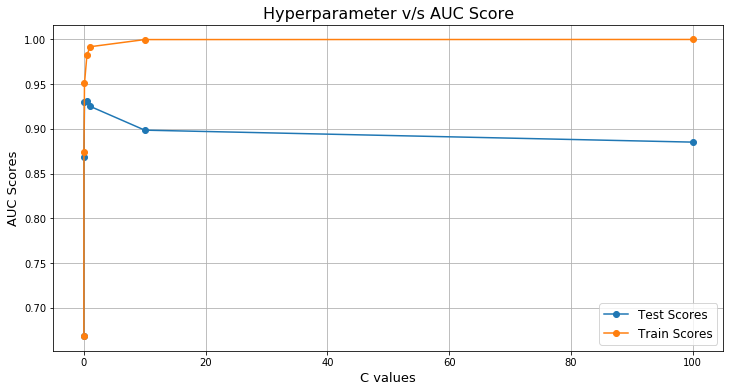


Time taken for cross-validation : 0:00:17.328341

Best model found using cross-validation : LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.931097031131461

Top positive class words : ['hooked' 'solved' 'pleasantly' 'harm' 'bonus' 'parties' 'compete'
 'father' 'whim' 'grateful']

Top negative class words : ['torres' 'immersion' 'descaled' 'ugh' 'morals' 'disappointing' 'worst'
 'thrash' 'mincement' 'metals']

sparsity = 0.9178279673234022


In [11]:
X_train, X_test, featurizer = featurize('binary_bow', standardize=False)
clf = cross_val(reg='l1')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8889
	Weighted f1-score on test data : 0.8949628764343969
	Weighted AUC score on test data : 0.9413248671404746

              precision    recall  f1-score   support

    negative       0.64      0.85      0.73      5242
    positive       0.97      0.90      0.93     24758

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.80      0.88      0.83     30000
weighted avg       0.91      0.89      0.89     30000





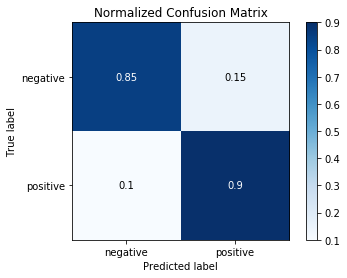

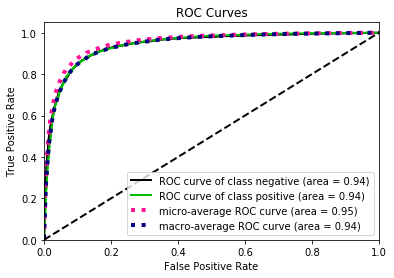

In [12]:
make_predictions(clf)

## Binary Bag of Words + L2 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   11.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   16.6s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   23.0s finished


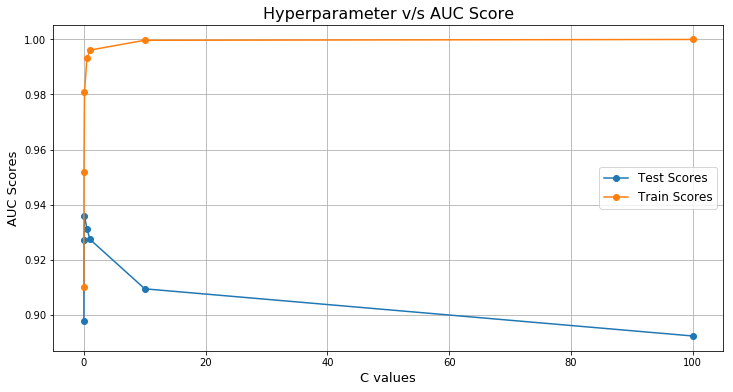


Time taken for cross-validation : 0:00:25.848315

Best model found using cross-validation : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.9358603495822189

Top positive class words : ['hooked' 'perfect' 'delicious' 'highly' 'wonderful' 'loves' 'pleasantly'
 'great' 'best' 'beat']

Top negative class words : ['disappointing' 'worst' 'terrible' 'awful' 'disappointment' 'horrible'
 'disappointed' 'weak' 'stale' 'bland']


In [13]:
X_train, X_test, featurizer = featurize('binary_bow', standardize=False)
clf = cross_val(reg='l2')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.89
	Weighted f1-score on test data : 0.8961200909609809
	Weighted AUC score on test data : 0.9452326140080619

              precision    recall  f1-score   support

    negative       0.64      0.86      0.73      5242
    positive       0.97      0.90      0.93     24758

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.80      0.88      0.83     30000
weighted avg       0.91      0.89      0.90     30000





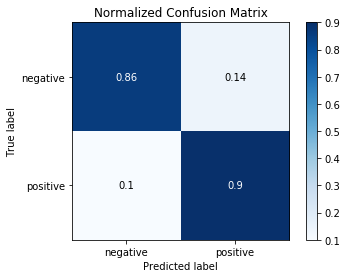

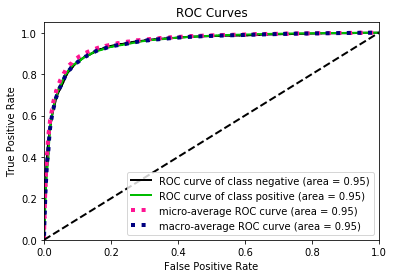

In [14]:
make_predictions(clf)

## Count based Bag of Words + L1 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    7.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    9.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   10.7s finished


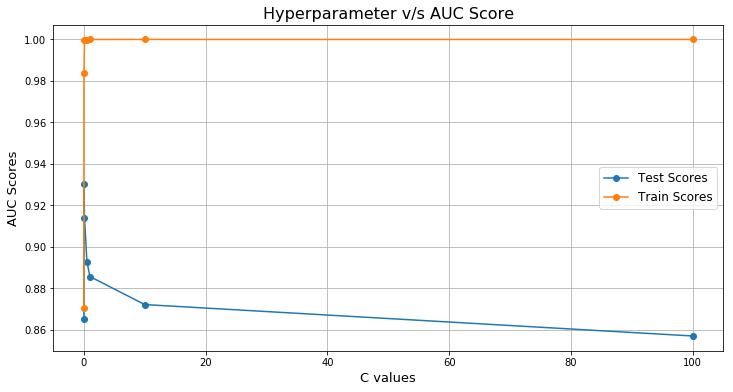


Time taken for cross-validation : 0:00:13.135837

Best model found using cross-validation : LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.9303526862046467

Top positive class words : ['great' 'best' 'delicious' 'good' 'perfect' 'love' 'loves' 'highly'
 'excellent' 'wonderful']

Top negative class words : ['not' 'disappointed' 'worst' 'terrible' 'disappointing' 'awful'
 'horrible' 'unfortunately' 'weak' 'disappointment']

sparsity = 0.8793431251697553


In [15]:
X_train, X_test, featurizer = featurize('bow')
clf = cross_val(reg='l1')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8977666666666667
	Weighted f1-score on test data : 0.9024487221096894
	Weighted AUC score on test data : 0.941461269545515

              precision    recall  f1-score   support

    negative       0.66      0.85      0.74      5242
    positive       0.97      0.91      0.94     24758

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.81      0.88      0.84     30000
weighted avg       0.91      0.90      0.90     30000





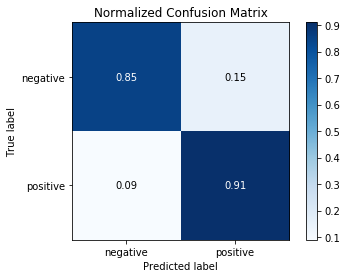

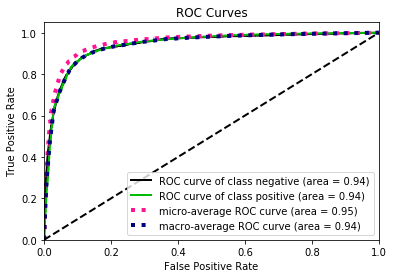

In [16]:
make_predictions(clf)

## Count based Bag of Words + L2 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   35.7s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   48.7s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   57.6s finished


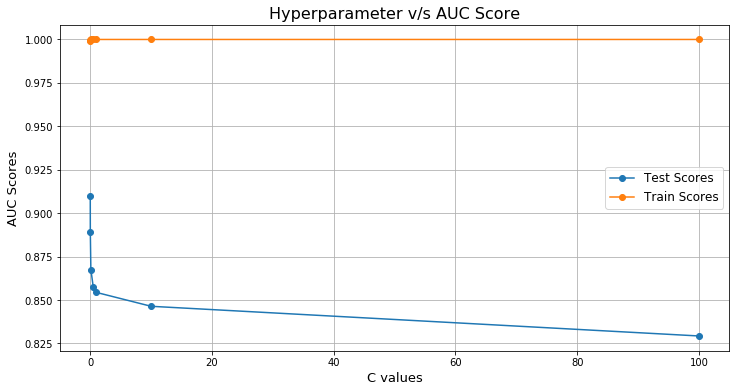


Time taken for cross-validation : 0:01:01.819760

Best model found using cross-validation : LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.9101222760849934

Top positive class words : ['great' 'best' 'good' 'delicious' 'love' 'loves' 'perfect' 'excellent'
 'nice' 'favorite']

Top negative class words : ['not' 'disappointed' 'worst' 'disappointing' 'awful' 'terrible'
 'horrible' 'would' 'weak' 'taste']


In [17]:
X_train, X_test, featurizer = featurize('bow')
clf = cross_val(reg='l2')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8958
	Weighted f1-score on test data : 0.898254566130745
	Weighted AUC score on test data : 0.9142083078815679

              precision    recall  f1-score   support

    negative       0.68      0.77      0.72      5242
    positive       0.95      0.92      0.94     24758

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.81      0.84      0.83     30000
weighted avg       0.90      0.90      0.90     30000





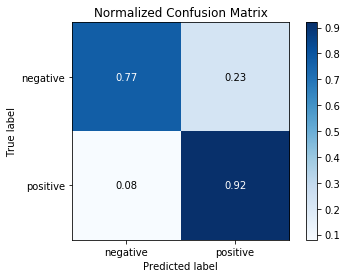

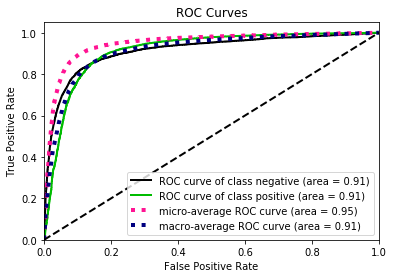

In [18]:
make_predictions(clf)

## TF-IDF + L1 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    9.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   10.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   11.9s finished


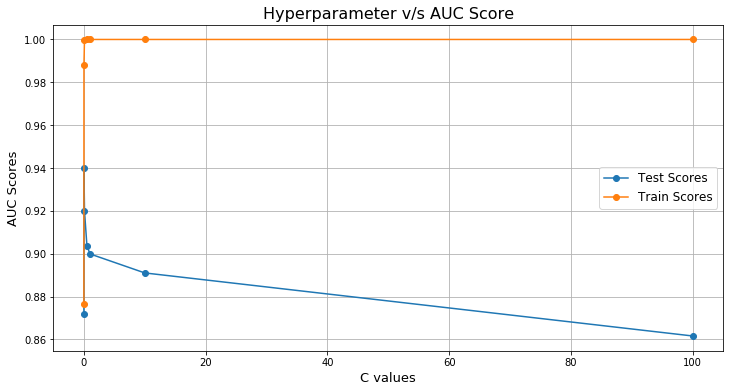


Time taken for cross-validation : 0:00:14.387205

Best model found using cross-validation : LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.9401356566403091

Top positive class words : ['great' 'best' 'delicious' 'good' 'perfect' 'love' 'loves' 'highly'
 'wonderful' 'excellent']

Top negative class words : ['not' 'worst' 'disappointed' 'disappointing' 'terrible' 'awful' 'taste'
 'horrible' 'disappointment' 'weak']

sparsity = 0.8534358481499279


In [19]:
X_train, X_test, featurizer = featurize('tfidf')
clf = cross_val(reg='l1')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8979
	Weighted f1-score on test data : 0.9023772182141016
	Weighted AUC score on test data : 0.9488314992908539

              precision    recall  f1-score   support

    negative       0.66      0.84      0.74      5242
    positive       0.96      0.91      0.94     24758

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.81      0.87      0.84     30000
weighted avg       0.91      0.90      0.90     30000





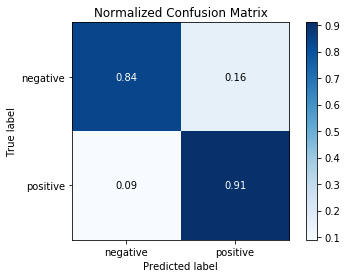

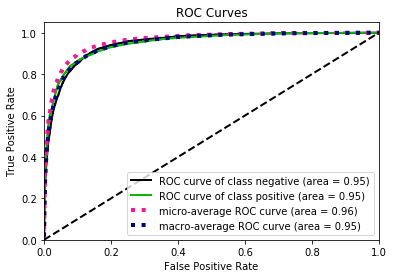

In [20]:
make_predictions(clf)

## TF-IDF + L2 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   27.5s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   30.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   35.1s finished


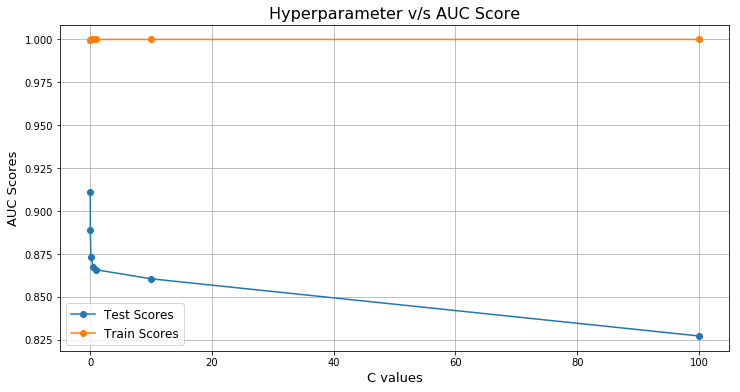


Time taken for cross-validation : 0:00:37.784274

Best model found using cross-validation : LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.9112831817566596

Top positive class words : ['great' 'best' 'good' 'delicious' 'love' 'loves' 'perfect' 'excellent'
 'nice' 'wonderful']

Top negative class words : ['not' 'disappointed' 'worst' 'disappointing' 'awful' 'terrible'
 'horrible' 'weak' 'taste' 'disappointment']


In [21]:
X_train, X_test, featurizer = featurize('tfidf')
clf = cross_val(reg='l2')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8798666666666667
	Weighted f1-score on test data : 0.8829080766726779
	Weighted AUC score on test data : 0.9084229118870282

              precision    recall  f1-score   support

    negative       0.64      0.73      0.68      5242
    positive       0.94      0.91      0.93     24758

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.79      0.82      0.80     30000
weighted avg       0.89      0.88      0.88     30000





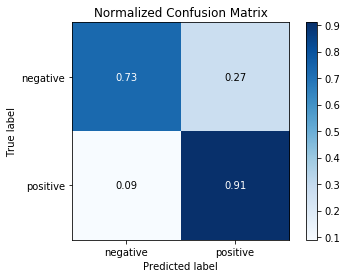

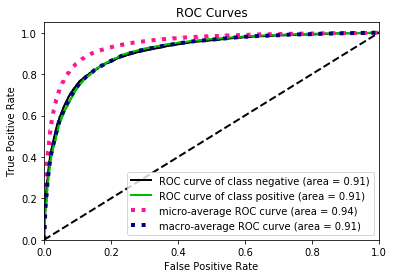

In [22]:
make_predictions(clf)

## AVG Word2Vec + L1 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  1.7min remaining:   55.8s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  1.9min remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  2.2min finished


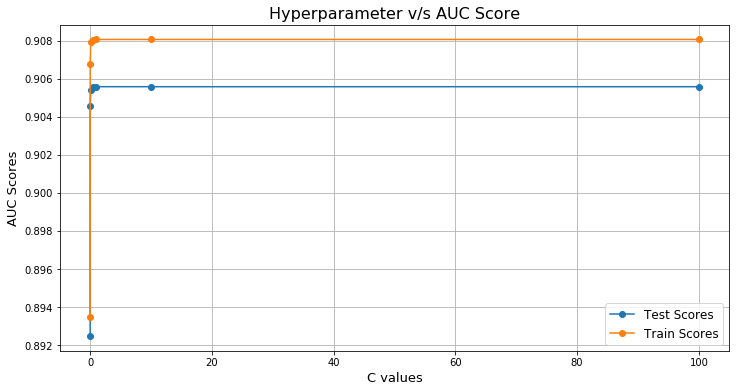


Time taken for cross-validation : 0:02:43.695702

Best model found using cross-validation : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.905579192420274

sparsity = 0.0


In [23]:
X_train, X_test, featurizer = featurize('w2v')
clf = cross_val(reg='l1')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8068
	Weighted f1-score on test data : 0.8258418493204523
	Weighted AUC score on test data : 0.9084661538187941

              precision    recall  f1-score   support

    negative       0.47      0.86      0.61      5242
    positive       0.96      0.79      0.87     24758

   micro avg       0.81      0.81      0.81     30000
   macro avg       0.72      0.83      0.74     30000
weighted avg       0.88      0.81      0.83     30000





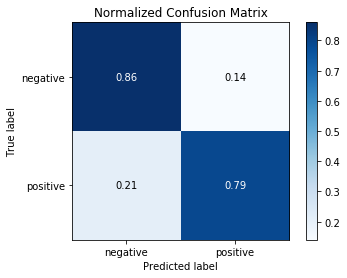

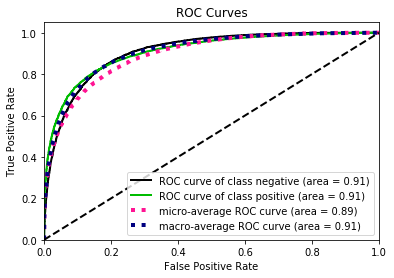

In [24]:
make_predictions(clf)

## AVG Word2Vec + L2 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    9.8s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   10.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   12.4s finished


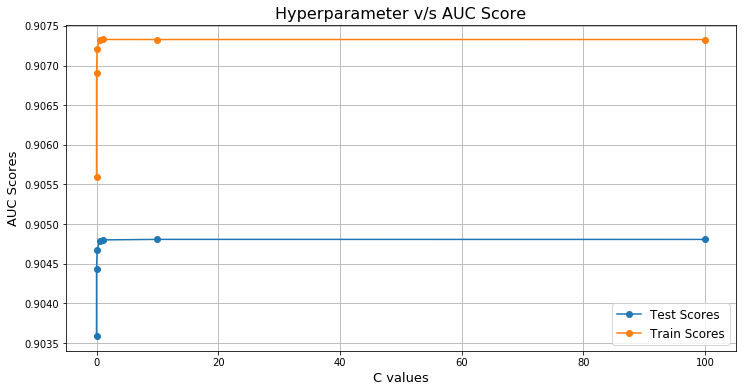


Time taken for cross-validation : 0:00:15.282647

Best model found using cross-validation : LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.9048066511434467


In [25]:
X_train, X_test, featurizer = featurize('w2v')
clf = cross_val(reg='l2')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.8072666666666667
	Weighted f1-score on test data : 0.8262535296541503
	Weighted AUC score on test data : 0.9083649451990963

              precision    recall  f1-score   support

    negative       0.47      0.86      0.61      5242
    positive       0.97      0.80      0.87     24758

   micro avg       0.81      0.81      0.81     30000
   macro avg       0.72      0.83      0.74     30000
weighted avg       0.88      0.81      0.83     30000





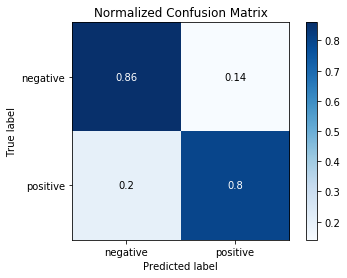

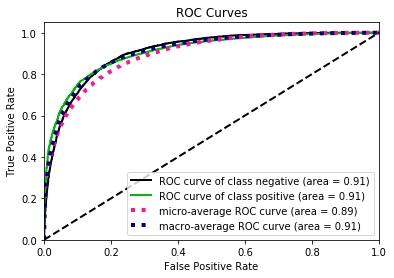

In [26]:
make_predictions(clf)

## TFIDF weighted Word2Vec  + L1 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  1.0min remaining:   34.1s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  1.1min remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.3min finished


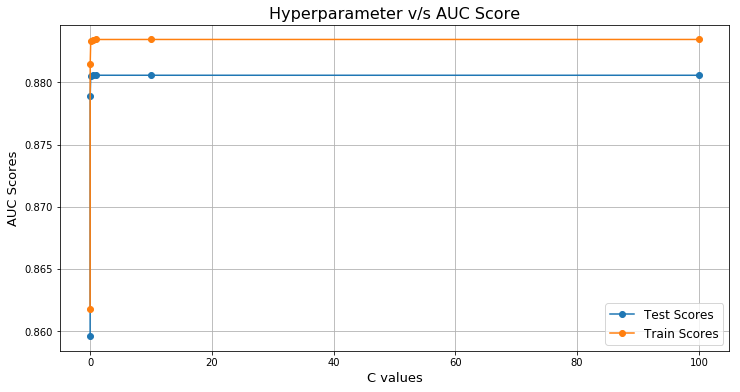


Time taken for cross-validation : 0:01:31.264547

Best model found using cross-validation : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.8805740723954126

sparsity = 0.0


In [27]:
X_train, X_test, featurizer = featurize('tfidf_w2v')
clf = cross_val(reg='l1')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7851333333333333
	Weighted f1-score on test data : 0.8069303886684662
	Weighted AUC score on test data : 0.8819984623995067

              precision    recall  f1-score   support

    negative       0.44      0.83      0.57      5242
    positive       0.95      0.78      0.86     24758

   micro avg       0.79      0.79      0.79     30000
   macro avg       0.70      0.80      0.71     30000
weighted avg       0.86      0.79      0.81     30000





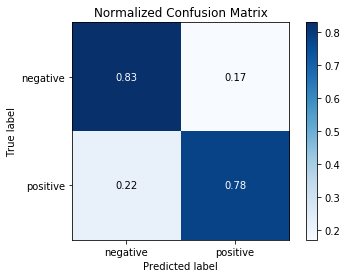

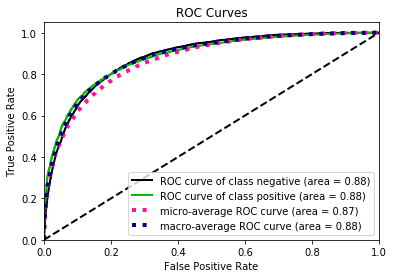

In [28]:
make_predictions(clf)

## TFIDF weighted Word2Vec  + L2 Regularization

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    9.8s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   10.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   11.9s finished


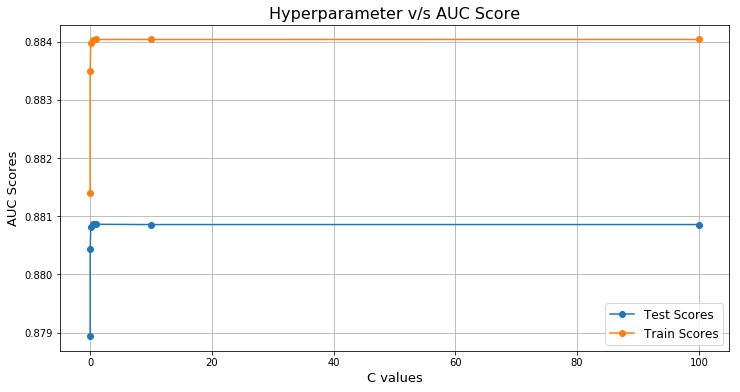


Time taken for cross-validation : 0:00:14.417401

Best model found using cross-validation : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

AUC score of the best model using cross-validation : 0.8808618267935127


In [29]:
X_train, X_test, featurizer = featurize('tfidf_w2v')
clf = cross_val(reg='l2')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7832
	Weighted f1-score on test data : 0.8053356427544031
	Weighted AUC score on test data : 0.8818501129853424

              precision    recall  f1-score   support

    negative       0.44      0.83      0.57      5242
    positive       0.95      0.77      0.85     24758

   micro avg       0.78      0.78      0.78     30000
   macro avg       0.70      0.80      0.71     30000
weighted avg       0.86      0.78      0.81     30000





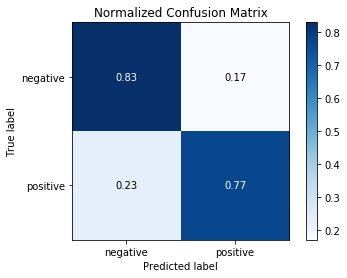

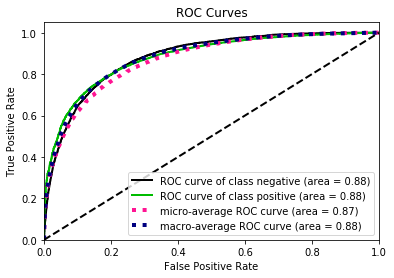

In [30]:
make_predictions(clf)

## Pertubation Test
We will perform the pertubation test corresponding to the best model i.e **Count based Bag Of Words** as features along with **L1 Regularization** and **C = 0.01**

In [11]:
X_train, X_test, featurizer = featurize('bow')
clf = LogisticRegression(penalty='l1', C=0.01, n_jobs=-1)
w = clf.fit(X_train, y_train).coef_[0]

e=np.random.normal(0,0.01)
X_train.data += e
w1 = clf.fit(X_train, y_train).coef_[0]

w += 10**-6
w1 += 10**-6

change = np.abs((w-w1)/w) * 100 
change = pd.Series(change)

In [12]:
for i in np.arange(0.90,1.01,0.01):
    print('{} percentile value is {}'.format(int(i*100),change.quantile(i)))

90 percentile value is 0.0
91 percentile value is 0.030013842974441804
92 percentile value is 0.07819876255057871
93 percentile value is 0.13500246820634287
94 percentile value is 0.21160189515357303
95 percentile value is 0.34148806960570277
96 percentile value is 0.6079514184061289
97 percentile value is 1.5931475922582066
98 percentile value is 20.86647377851639
99 percentile value is 97.59183945062482
100 percentile value is 1418269.8882277543


In [13]:
for i in np.arange(99,100.1,0.1):
    print('{} percentile value is {}'.format(np.round(i,1),change.quantile(i/100)))

99.0 percentile value is 97.59183945062472
99.1 percentile value is 99.72802855954706
99.2 percentile value is 100.35117736956208
99.3 percentile value is 141.25292189770826
99.4 percentile value is 222.01867292033415
99.5 percentile value is 394.0663823539711
99.6 percentile value is 706.2657834870643
99.7 percentile value is 1400.3104492363864
99.8 percentile value is 6536.519579363084
99.9 percentile value is 96898.30707213249
100.0 percentile value is 1418269.8882273054


Lets set the threshold to 11686 %

In [19]:
num = (change > 6536).sum()
print('{} features have % change greater than the threshold'.format(num))
print('\nMulticollinear features :', np.take(featurizer.get_feature_names(), np.where(change>6536)[0]))

96 features have % change greater than the threshold

Multicollinear features : ['abrotanum' 'accountable' 'acetaia' 'acorns' 'aggrevation' 'alice'
 'alludes' 'allus' 'alotted' 'amonth' 'artemisia' 'artifact' 'attaracted'
 'auspices' 'autospout' 'awckward' 'bale' 'behinds' 'besty' 'brainiac'
 'carbnada' 'cattledog' 'centenario' 'clus' 'coastproducts' 'collecter'
 'congou' 'couture' 'cremoso' 'decidedvto' 'decocainized' 'deluded'
 'dicolored' 'disrespectful' 'efim' 'endoscopic' 'enegised' 'envoironment'
 'ethnicity' 'facially' 'familglia' 'ferminted' 'fisheries' 'forestall'
 'fundraising' 'gaping' 'gbs' 'gordo' 'hessians' 'homie' 'idesas' 'idris'
 'insults' 'irrefutable' 'irretrievably' 'izzies' 'jeanne' 'lastest'
 'littleuns' 'mandy' 'mazzetti' 'mmmmmmmmmmmelt' 'modenaceti' 'mollusks'
 'normaly' 'nuby' 'ornamec' 'outten' 'overstewed' 'paleta'
 'perfectionistic' 'pommes' 'porker' 'predecessors' 'ratch' 'reformulates'
 'renovated' 'revelations' 'revenues' 'rhizome' 'schmegecky' 'suntory'

## Conclusions
The best Model was attained using **TF-IDF features** and **L1 Regularization** with **C = 0.01**

    accuracy on test data : 0.90
    Weighted f1-score on test data : 0.90
    Weighted AUC score on test data : 0.95

